In [6]:
import pennylane as qml
from pennylane import numpy as np
from pennylane import qchem
from pennylane.qchem import excitations
import matplotlib.pyplot as plt
import os

In [7]:
# Water molecule
symbols = ["O", "H", "H"]

# Geometry in Angstroms
coordinates = np.array([
    [0.000000,  0.000000,  0.000000],  # Oxygen at origin
    [0.758602,  0.000000,  0.504284],  # Hydrogen 1
    [-0.758602, 0.000000,  0.504284]   # Hydrogen 2
])

In [8]:
# Build the Hamiltonian
hamiltonian, qubits = qchem.molecular_hamiltonian(symbols, coordinates, charge=0)

electrons = 10  # Total electrons in water molecule
hf = qchem.hf_state(electrons=electrons, orbitals=qubits)

In [9]:
num_wires = qubits
dev = qml.device("default.qubit", wires=num_wires)
@qml.qnode(dev)
def exp_energy(state):
    qml.BasisState(np.array(state), wires=range(num_wires))
    return qml.expval(hamiltonian)

exp_energy(hf)

tensor(-72.86837737, requires_grad=True)

In [10]:
# Single excitations allow orbital relaxation, which can capture important electron correlation
# Double excitations capture dynamic correlation — the subtle inter-electron repulsion effects
singles, doubles = qchem.excitations(electrons, qubits)

def ansatz(params_singles, params_doubles):
    qml.BasisState(hf, wires=range(num_wires))
    
    # Apply single excitations
    for i, excitation in enumerate(singles):
        qml.SingleExcitation(params_singles[i], wires=excitation)
    
    # Apply double excitations
    for i, excitation in enumerate(doubles):
        qml.DoubleExcitation(params_doubles[i], wires=excitation)

In [15]:
@qml.qnode(dev)
def cost_function(params_singles, params_doubles):
    ansatz(params_singles, params_doubles)
    return qml.expval(hamiltonian)

# Initialize both parameter sets
initial_params_singles = np.zeros(len(singles), requires_grad=True)
initial_params_doubles = np.zeros(len(doubles), requires_grad=True)

# Evaluate initial energy
cost_function(initial_params_singles, initial_params_doubles)

tensor(-72.86837737, requires_grad=True)

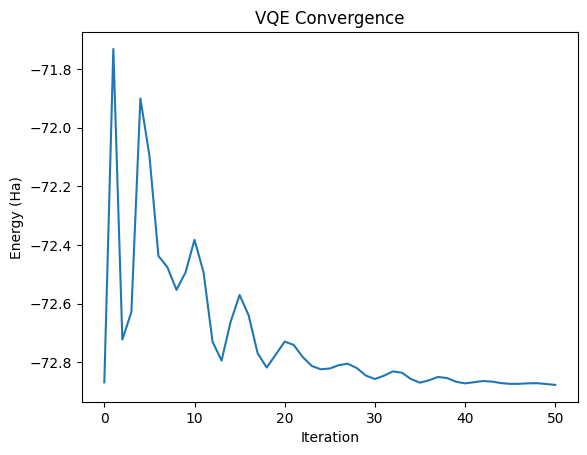

In [20]:
theta_singles = np.zeros(len(singles), requires_grad=True)
theta_doubles = np.zeros(len(doubles), requires_grad=True)

energy = [cost_function(theta_singles, theta_doubles)]
angle_singles = [theta_singles]
angle_doubles = [theta_doubles]

opt = qml.AdamOptimizer(stepsize=0.1)
max_iterations = 50
for n in range(max_iterations):
    # Update both sets of parameters
    (theta_singles, theta_doubles), prev_energy = opt.step_and_cost(
        cost_function, theta_singles, theta_doubles
    )

    # Append energy and parameter tracking
    energy.append(cost_function(theta_singles, theta_doubles))
    angle_singles.append(theta_singles)
    angle_doubles.append(theta_doubles)

# Plotting VQE convergence
plt.plot(range(len(energy)), energy)
plt.xlabel('Iteration')
plt.ylabel('Energy (Ha)')
plt.title('VQE Convergence')
plt.show()

In [ ]:
print(f"Final ground state energy: {energy[-1]:.8f} Ha")
print(f"Final single excitation parameters: {theta_singles[0]:.8f}, {theta_singles[1]:.8f}")
print(f"Final double excitation parameters: {theta_doubles[0]:.8f}, {theta_doubles[1]:.8f}")

Final ground state energy: -72.87712785 Ha
Final single excitation parameters: -0.00162360, 0.00258344
Final double excitation parameters: 0.00083979, -0.00275219


In [26]:
@qml.qnode(dev)
def ground_state(params_singles, params_doubles):
    ansatz(params_singles, params_doubles)
    return qml.state()

final_state = ground_state(theta_singles, theta_doubles)

# Find non-zero (or near non-zero) entries
threshold = 1e-2  # Recommended smaller threshold to capture all significant amplitudes
non_zero_indices = np.where(np.abs(final_state) > threshold)[0]
non_zero_amplitudes = final_state[non_zero_indices]

# Build the full ket notation string
ket_terms = []
for idx, amp in zip(non_zero_indices, non_zero_amplitudes):
    binary_state = f"|{idx:0{num_wires}b}>"
    # Format the amplitude nicely
    amp_str = f"{amp.real:.4f}" if np.isclose(amp.imag, 0, atol=1e-6) else f"({amp.real:.4f} + {amp.imag:.4f}j)"
    ket_terms.append(f"{amp_str}{binary_state}")

# Join all terms into one quantum state expression
ket_notation = " + ".join(ket_terms)

# Print the final ground state in ket notation
print(f"Ground state of H₂O:\n|ψ⟩ = {ket_notation}")

Ground state of H₂O:
|ψ⟩ = -0.0160|11001111111100> + 0.0156|11011011111001> + 0.0171|11100111110110> + -0.0323|11110011110011> + -0.0105|11110011111100> + -0.0244|11111100110011> + -0.0211|11111111001100> + 0.9979|11111111110000>


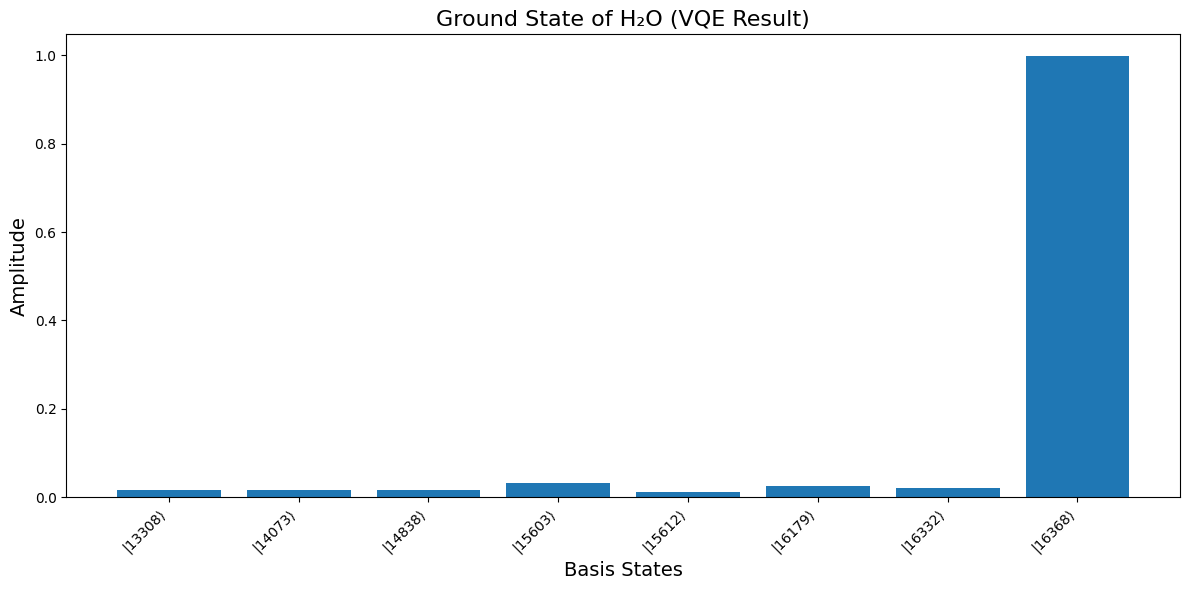

In [28]:
# Ensure the "images" directory exists
os.makedirs('images', exist_ok=True)

# Prepare labels and amplitudes for the plot
labels = [f"|{idx}⟩" for idx in non_zero_indices]  # No extra brackets

amplitudes = np.abs(non_zero_amplitudes)

# Plotting the bar plot
plt.figure(figsize=(12, 6))
plt.bar(labels, amplitudes)
plt.xlabel('Basis States', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.title('Ground State of H₂O (VQE Result)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Save the figure to the "images" directory
plt.savefig('images/H2O_ground_state.png')
plt.show()